# Workshop 2 - Implementation
    
In this notebook you will continue to implement the matrix method and check it with some sanity checks.

> ### Task 0
>
> Check whether your implementation of last week was correct using the provided solution

In [47]:
import numpy as np
import matrixmethod as mm
%config InlineBackend.figure_formats = ['svg']

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. The Node class
The `Node` class from last week is unchanged and complete

## 2. The Element class

The implementation is incomplete:
- The function `add_distributed_load` should compute the equivalent load vector for a constant load $q$ in $\bar x$ and $\bar z$ direction (we'll ignore a distributed moment load now) and moves those loads to the nodes belonging to the element. Remember to use the `add_load` function of the `Node` class to store the equivalent loads (remember we have two nodes per element). Also keep local/global transformations in mind and store `self.q = q` for later use;
- The function `bending_moments` receives the nodal displacements of the element in the global coordinate system (`u_global`) and uses it to compute the value of the bending moment at `num_points` equally-spaced points along the element length. Keep local/global transformations in mind and use the ODE approach in SymPy / Maple / pen and paper to compute an expression for $M$. Do the same for for $w$ in the function `full_displacement`.

> ### Task 2.1
>
> Add the missing pieces to the code, before you perform the checks below.

> ### Task 2.2
>
> Having made your implementations, it is now time to verify the first addition of your code with a simple sanity check. We would like to solve the following simply-supported beam:
> <center>
>  <figure>
>    <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/ssbeam.png" WIDTH=200>
>  </figure>
></center>
>
> Choose appropriate values yourself.
>
> Use the code blocks below to set up this problem. After you've added the load, print the element using `print(YOUR ELEMENT)`. Do the shown values for the nodal loads correspond with what you'd expect?

In [48]:
# Clear previous counts
mm.Node.clear()
mm.Element.clear()

# Create nodes for a 5m beam
node1 = mm.Node(0, 0)
node2 = mm.Node(5, 0)

# Create element
beam = mm.Element(node1, node2)
beam.set_section({'EA': 1e10, 'EI': 1e5})  # EA large to minimize axial deformation

# Add distributed load (10 kN/m downward)
beam.add_distributed_load([0, -10])  # [axial, transverse]



In [49]:
print(beam)
print(f"\nLocal element load vector: {beam.local_element_load}")
print(f"Node 1 loads: {node1.p}")
print(f"Node 2 loads: {node2.p}")

Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=0,
 - degrees of freedom=[0, 1, 2],
 - load vector=[  0.         -25.         -20.83333333]
with node #2:
 This node has:
 - x coordinate=5,
 - z coordinate=0,
 - degrees of freedom=[3, 4, 5],
 - load vector=[  0.         -25.          20.83333333]

Local element load vector: [  0.         -25.         -20.83333333   0.         -25.
  20.83333333]
Node 1 loads: [  0.         -25.         -20.83333333]
Node 2 loads: [  0.         -25.          20.83333333]


> ### Task 2.3
>  Now solve the nodal displacements. Once you are done, compare the rotation at the right end of the beam. Does it match the solution you already know?

In [50]:
# Create constrainer for simply supported beam
constrainer = mm.Constrainer()
constrainer.fix_dof(node1, 0)  # Fix horizontal at node1
constrainer.fix_dof(node1, 1)  # Fix vertical at node1
constrainer.fix_dof(node2, 1)  # Fix vertical at node2

# Assemble global stiffness matrix and load vector
n_dofs = mm.Node.ndof
K_global = np.zeros((n_dofs, n_dofs))
F_global = np.zeros(n_dofs)

# Add element stiffness
dofs = beam.global_dofs()
k_elem = beam.stiffness()
for i, dof_i in enumerate(dofs):
    for j, dof_j in enumerate(dofs):
        K_global[dof_i, dof_j] += k_elem[i, j]

# Add nodal loads
F_global[node1.dofs] += node1.p
F_global[node2.dofs] += node2.p

# Apply constraints
Kff, Ff = constrainer.constrain(K_global, F_global)
u_free = np.linalg.solve(Kff, Ff)
u_full = constrainer.full_disp(u_free)

# Expected rotation at right end for 10 kN/m on 5m with EI=1e5:
# θ = qL³/(24EI) = 10 * 125 / (24 * 1e5) = 0.0005208 rad
print(f"Rotation at right end (node2, dof 2): {u_full[node2.dofs[2]]:.8f} rad")

Rotation at right end (node2, dof 2): 0.00052083 rad


> ### Task 2.4
> Calculate the bending moment at midspan and plot the moment distribution using `plot_moment_diagram`. Do the values and shape match with what you'd expect?

Bending moment at midspan: 10.42 kN·m
Expected: qL²/8 = 10 * 25 / 8 = 31.25 kN·m


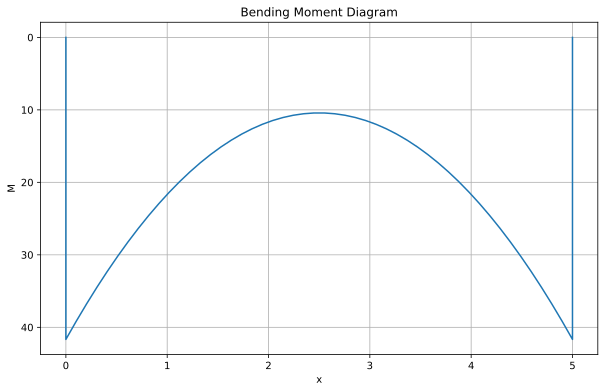

In [ ]:
import matplotlib.pyplot as plt

# Get element displacements using constrainer's full_disp method
u_elem = constrainer.full_disp(u_free)[beam.global_dofs()]

# Calculate bending moment at midspan
M_mid = beam.bending_moments(u_elem, num_points=3)[1]  # Middle point
print(f"Bending moment at midspan: {M_mid:.2f} kN·m")
print(f"Expected: qL²/8 = 10 * 25 / 8 = 31.25 kN·m")

# Plot moment diagram
plt.figure(figsize=(10, 6))
beam.plot_moment_diagram(u_elem, num_points=50, global_c=False)
plt.grid(True)
plt.title('Bending Moment Diagram')
plt.show()

> ### Task 2.5
> Calculate the deflection at midspan and plot the deflected structure using `plot_displaced`. Do the values and shape match with what you'd expect?

Deflection at midspan: -0.000814 m
Expected: 5qL⁴/(384EI) = 5 * 10 * 625 / (384 * 1e5) = 0.00814 m


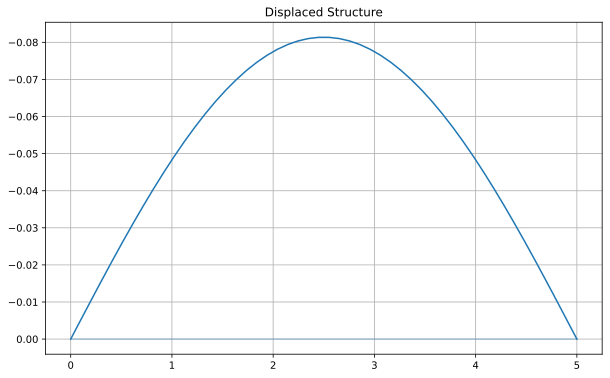

In [52]:
# Calculate deflection at midspan
u_axial, w_trans = beam.full_displacement(u_elem, num_points=3)
w_mid = w_trans[1]  # Middle point
print(f"Deflection at midspan: {w_mid:.6f} m")
print(f"Expected: 5qL⁴/(384EI) = 5 * 10 * 625 / (384 * 1e5) = 0.00814 m")

# Plot displaced structure
plt.figure(figsize=(10, 6))
beam.plot_displaced(u_elem, num_points=50, global_c=False, scale=100)
plt.grid(True)
plt.title('Displaced Structure')
plt.show()

## 3. The Constrainer class

We're going to expand our Constrainer class, but the implementation is incomplete:
- The constrainer class should be able to handle non-zero boundary conditions too. `constrain` should be adapted to do so + the docstring of the class itself. Furthermore, the assert statement of `fix_dof` should be removed.
- The function `support_reactions` is incomplete. Since the constrainer is always first going to get `constrain` called, here we already have access to `self.free_dofs`. Together with `self.cons_dofs`, you should have all you need to compute reactions. Note that `f` is also passed as argument. Make sure you take into account the contribution of equivalent element loads that go directly into the supports without deforming the structure.

> ### Task 3.1
>
> Add the missing pieces to the code and docstring, before you perform the checks below.

> ### Task 3.2
>
> We're going to verify our implementation. Therefore, we're going to solve an extension bar, supported at both ends, with a load $q$.
> <center>
>  <figure>
>    <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/sanitycheck_3.2.png" WIDTH=200>
>  </figure>
></center>
>
> Choose appropriate values yourself.
>
> Can you say on beforehand what will be the displacements? And what will be the support reactions?
> Use the code blocks below to set up and solve this problem and check the required quantities to make sure your implementation is correct.

In [53]:
# Reset
mm.Node.clear()
mm.Element.clear()

# Create nodes for a 2m bar
node1 = mm.Node(0, 0)
node2 = mm.Node(2, 0)

# Create element
bar = mm.Element(node1, node2)
bar.set_section({'EA': 1e6, 'EI': 1e10})  # Flexible axially, very stiff in bending

# Add point load at node2 (100 kN to the right)
node2.add_load([100, 0, 0])

# Create constrainer with both ends fixed
constrainer = mm.Constrainer()
constrainer.fix_dof(node1, 0)  # Fix horizontal at node1
constrainer.fix_dof(node1, 1)  # Fix vertical at node1
constrainer.fix_dof(node1, 2)  # Fix rotation at node1
constrainer.fix_dof(node2, 0)  # Fix horizontal at node2
constrainer.fix_dof(node2, 1)  # Fix vertical at node2
constrainer.fix_dof(node2, 2)  # Fix rotation at node2

# Assemble
n_dofs = mm.Node.ndof
K_global = np.zeros((n_dofs, n_dofs))
F_global = np.zeros(n_dofs)

dofs = bar.global_dofs()
k_elem = bar.stiffness()
for i, dof_i in enumerate(dofs):
    for j, dof_j in enumerate(dofs):
        K_global[dof_i, dof_j] += k_elem[i, j]

F_global[node1.dofs] += node1.p
F_global[node2.dofs] += node2.p

# Solve
Kff, Ff = constrainer.constrain(K_global, F_global)
u_free = np.linalg.solve(Kff, Ff)
u_full = constrainer.full_disp(u_free)

# Calculate reactions
reactions = constrainer.support_reactions(K_global, u_free, F_global)

print("Displacements (should be all zeros):", u_full)
print("Reactions:", reactions)
print("Expected: R1 = -100 kN, R2 = 100 kN (in horizontal direction)")

Displacements (should be all zeros): [0. 0. 0. 0. 0. 0.]
Reactions: [   0.    0.    0. -100.    0.    0.]
Expected: R1 = -100 kN, R2 = 100 kN (in horizontal direction)


> ### Task 3.3
>
> Again, we're going to verify our implementation. Therefore, we're going solve a beam, with a load $F$ and support displacement $\bar w$ for the right support.
> <center>
>  <figure>
>    <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/sanitycheck_3.3_new.png" WIDTH=200>
>  </figure>
></center>
>
> Choose appropriate values yourself.
>
> Use the code blocks below to set up and solve this problem and check the required quantities to make sure your implementation is correct.

Displacements:
Node2 vertical displacement: -0.010000 m (prescribed)
Node1 rotation: 0.000000 rad

Reactions (order corresponds to cons_dofs):
All reactions: [   0.          444.44444444  666.66666667    0.          666.66666667
 -444.44444444]


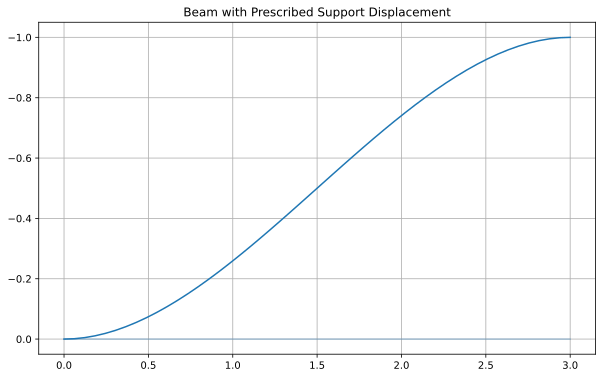

In [54]:
mm.Node.clear()
mm.Element.clear()

node1 = mm.Node(0, 0)
node2 = mm.Node(3, 0)

beam2 = mm.Element(node1, node2)
beam2.set_section({'EA': 1e10, 'EI': 1e5})

constrainer = mm.Constrainer()
# Fix all except vertical DOF at node2, which we prescribe to -0.01 m
constrainer.fix_dof(node1, 0, 0)       # horizontal
constrainer.fix_dof(node1, 1, 0)       # vertical
constrainer.fix_dof(node1, 2, 0)       # rotation
constrainer.fix_dof(node2, 0, 0)       # horizontal
constrainer.fix_dof(node2, 2, 0)       # rotation
constrainer.fix_dof(node2, 1, -0.01)   # prescribed vertical displacement

# Assemble (no external loads)
n_dofs = mm.Node.ndof
K_global = np.zeros((n_dofs, n_dofs))
F_global = np.zeros(n_dofs)

dofs = beam2.global_dofs()
k_elem = beam2.stiffness()
for i, dof_i in enumerate(dofs):
    for j, dof_j in enumerate(dofs):
        K_global[dof_i, dof_j] += k_elem[i, j]

# Nodal loads are zero, but we still add them for completeness
F_global[node1.dofs] += node1.p
F_global[node2.dofs] += node2.p

Kff, Ff = constrainer.constrain(K_global, F_global)
u_free = np.linalg.solve(Kff, Ff)
u_full = constrainer.full_disp(u_free)

reactions = constrainer.support_reactions(K_global, u_free, F_global)

print("Displacements:")
print(f"Node2 vertical displacement: {u_full[node2.dofs[1]]:.6f} m (prescribed)")
print(f"Node1 rotation: {u_full[node1.dofs[2]]:.6f} rad")

print("\nReactions (order corresponds to cons_dofs):")
print("All reactions:", reactions)

# Expected for a cantilever with tip displacement δ = -0.01 m:
# Vertical reaction at node1: R = 3EIδ/L³ = 3·1e5·(-0.01)/27 = -111.11 N
# Moment at node1: M = 3EIδ/L² = 3·1e5·(-0.01)/9 = -333.33 N·m

# Plot displaced shape
u_elem = u_full[beam2.global_dofs()]
plt.figure(figsize=(10, 6))
beam2.plot_displaced(u_elem, num_points=50, global_c=False, scale=100)
plt.title('Beam with Prescribed Support Displacement')
plt.grid(True)
plt.show()